# ConnectX: Deep RL with Stable_baseline3 and Gymnasium (PPO)

<div style=" background-color: rgb(218, 255, 215);
             border-style: outset;
             padding: 10px;
             margin: 10px;
             text-indent: 10px;
             text-align: justify;
             letter-spacing: 1px;
             line-height: 200%">
    <h3>&#x1F916; SUMMARY &#x1F916; </h3>
    <ul >
        <li style = "margin: 10px">I trained a vector agent in the Gymnasium environment using the Stable_baseline3 PPO algorithm.</li> 
        <li style = "margin: 10px">During training, I implemented learning rate decay and used a random agent for the first 500K time steps and negamax agent for the following 500K time steps, ultimately training my model for a total of 1M time steps. </li> 
        <li style = "margin: 10px">To generate the submission file, I passed the trained action network parameters to an equivalent pytorch deep network and created a function to predict action with it. </li> 
        <li style = "margin: 10px">As a beginner, I welcome your comments.&#x1F60A; But I kindly request that you provide constructive feedback in a gentle manner, as I am new to this and still learning. &#x1F605; And please rate my notebook if you find it helpful. &#x1F917; </li></ul></div> 

## Importing Useful Libraries

<div style="  font-size: 18px;  

              border: 2px solid gray;
              padding: 8px;
              text-indent: 50px;
              text-align: justify;">
<ul><li>I trained a vector agent in the Gymnasium environment using the Stable_baseline3 Actor critic network with PPO.</li>
<li>During training, I implemented learning rate decay and used a random agent for the first 500K time steps and negamax for the following 500K time steps, ultimately training my model for a total of 1M time steps.</li>
<li>To generate the submission file function, I passed the trained action network parameters to an equivalent pytorch deep network and submitted my results. </li>
<li>As a beginner, I welcome your comments. Please rate my notebook if you find it helpfli. This is only the third deep RL model I have trained, so I appreciate your kindness.</li></ul></div>

In [1]:
import gymnasium as gym
import stable_baselines3 as sb3

import pandas as pd 
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
import numpy as np 

import matplotlib.pyplot as plt
%matplotlib inline 

import os
import torch as th
from torch import nn as nn
import torch.nn.functional as F

import time
from stable_baselines3.common.monitor import Monitor
from random import choice
from gymnasium import spaces
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement
from stable_baselines3.common.env_checker import check_env

In [2]:
from kaggle_environments import evaluate, make, utils

Loading environment lux_ai_s2 failed: No module named 'vec_noise'


## Checking Envorinment, converting to Gymnasium envorinment

In [3]:
#Exploring the environment
env = make("connectx",debug=True)

display(env.specification.observation)
print('*'*66)
display(env.specification.configuration)
print('*'*66)
display(env.specification.action)

{'remainingOverageTime': {'description': 'Total remaining banked time (seconds) that can be used in excess of per-step actTimeouts -- agent is disqualified with TIMEOUT status when this drops below 0.',
  'shared': False,
  'type': 'number',
  'minimum': 0,
  'default': 60},
 'step': {'description': 'Current step within the episode.',
  'type': 'integer',
  'shared': True,
  'minimum': 0,
  'default': 0},
 'board': {'description': 'Serialized grid (rows x columns). 0 = Empty, 1 = P1, 2 = P2',
  'type': 'array',
  'shared': True,
  'default': []},
 'mark': {'defaults': [1, 2],
  'description': 'Which checkers are the agents.',
  'enum': [1, 2]}}

******************************************************************


{'episodeSteps': {'description': 'Maximum number of steps in the episode.',
  'type': 'integer',
  'minimum': 1,
  'default': 1000},
 'actTimeout': {'description': 'Maximum runtime (seconds) to obtain an action from an agent.',
  'type': 'number',
  'minimum': 0,
  'default': 2},
 'runTimeout': {'description': 'Maximum runtime (seconds) of an episode (not necessarily DONE).',
  'type': 'number',
  'minimum': 0,
  'default': 1200},
 'columns': {'description': 'The number of columns on the board',
  'type': 'integer',
  'default': 7,
  'minimum': 1},
 'rows': {'description': 'The number of rows on the board',
  'type': 'integer',
  'default': 6,
  'minimum': 1},
 'inarow': {'description': 'The number of checkers in a row required to win.',
  'type': 'integer',
  'default': 4,
  'minimum': 1},
 'agentTimeout': {'description': 'Obsolete field kept for backwards compatibility, please use observation.remainingOverageTime.',
  'type': 'number',
  'minimum': 0,
  'default': 60},
 'timeout': {'

******************************************************************


{'description': 'Column to drop a checker onto the board.',
 'type': 'integer',
 'minimum': 0,
 'default': 0}

In [4]:
print(*env.agents)

random negamax


In [5]:
#Playing an episode of the environment using random agent vs negamax
env = make("connectx", debug=True)
env.run(["negamax", "random"])
env.render(mode="ipython")

In [6]:
#turning envorinment stable-baselines3 compatible
#The original code at here: https://www.kaggle.com/code/alexisbcook/deep-reinforcement-learning 
#which is compatible with gym but not with gymnasium altered to be compatible with gymnasium and stable_baselines3
#changed reward function; imposed heavy penalty for invalid actions

class ConnectFourGym(gym.Env):
    ks_env = make("connectx", debug=True)
    def __init__(self, agent2="random"):
        
        self.env = ConnectFourGym.ks_env.train([None, agent2])
        self.rows = ConnectFourGym.ks_env.configuration.rows
        self.columns = ConnectFourGym.ks_env.configuration.columns
        # Learn about spaces here: http://gym.openai.com/docs/#spaces
        self.action_space = spaces.Discrete(self.columns)
        self.observation_space = spaces.Box(low=0, high=2, 
                                            shape=(1,self.rows,self.columns), dtype=int)
        # Tuple corresponding to the min and max possible rewards
        self.reward_range = (-100, 1)
        # StableBaselines throws error if these are not defined
        self.spec = None
        self.metadata = None
    def reset(self,seed=0):
        self.obs = self.env.reset()
        return np.array(self.obs['board']).reshape(1,self.rows,self.columns) ,\
                ConnectFourGym.ks_env.reset()[0]['info']
    def change_reward(self, old_reward, done):
        if old_reward == 1: # The agent won the game
            return 1
        elif done: # The opponent won the game
            return -1
        else: # Reward 1/42
            return 1/(self.rows*self.columns)
    def step(self, action):
        # Check if agent's move is valid
        is_valid = (self.obs['board'][int(action)] == 0)
        if is_valid: # Play the move
            self.obs, old_reward, done, _ = self.env.step(int(action))
            terminated = truncated= done
            reward = self.change_reward(old_reward, done)
        else: # End the game and penalize agent
            reward, done, _ = -100, True, {}
            terminated = truncated= done
        return np.array(self.obs['board']).reshape(1,self.rows,self.columns), reward, terminated,truncated, _

In [7]:
env = ConnectFourGym()

In [8]:
check_env(env)

/home/pelin/Desktop/advancedml/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py:30: UserWarning: It seems that your observation  is an image but its `dtype` is (int64) whereas it has to be `np.uint8`. If your observation is not an image, we recommend you to flatten the observation to have only a 1D vector
  warnings.warn(
/home/pelin/Desktop/advancedml/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py:38: UserWarning: It seems that your observation space  is an image but the upper and lower bounds are not in [0, 255]. Because the CNN policy normalize automatically the observation you may encounter issue if the values are not in that range.
  warnings.warn(
/home/pelin/Desktop/advancedml/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py:51: UserWarning: The minimal resolution for an image is 36x36 for the default `CnnPolicy`. You might need to use a custom features extractor cf. https://stable-baselines3.readthedocs.io/en/master/gui

In [9]:
display(env.observation_space)

Box(0, 2, (1, 6, 7), int64)

In [10]:
env.observation_space.sample()

array([[[2, 0, 2, 2, 0, 1, 2],
        [2, 0, 2, 0, 0, 0, 1],
        [2, 1, 2, 0, 2, 1, 0],
        [2, 2, 0, 2, 2, 0, 0],
        [1, 0, 2, 1, 2, 1, 2],
        [1, 1, 1, 1, 0, 1, 0]]])

In [11]:
env = Monitor(env)
env = DummyVecEnv([lambda: env])

## Training my vector agent with SB3  PPO Algorithm

In [12]:
#code ref: https://github.com/araffin/rl-baselines-zoo/blob/master/utils/utils.py#L225
def linear_schedule(initial_value):
    """
    Linear learning rate schedule.

    :param initial_value: (float or str)
    :return: (function)
    """
    if isinstance(initial_value, str):
        initial_value = float(initial_value)

    def func(progress):
        """
        Progress will decrease from 1 (beginning) to 0
        :param progress: (float)
        :return: (float)
        """
        return progress * initial_value

    return func

In [13]:
# Creating a PPO agent using a designed vector as the observation.
agent = sb3.PPO('MlpPolicy', 
                env, 
                n_steps=1536,
                ent_coef = 0.001,
                n_epochs = 8,
                gae_lambda = 0.8365,
                learning_rate = linear_schedule(3e-4), 
                batch_size = 512,
                clip_range = 0.4,
                policy_kwargs = {'log_std_init': -2, 'ortho_init':False},
                verbose=1)

Using cpu device


In [14]:
#Examining the agent network architectures.
print(agent.policy)

ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=42, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=42, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=7, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)


In [15]:
#Creating an evaluation callback that is called every at regular intervals and renders the episode
eval_log_path = './log_connectx'
eval_env= Monitor(Monitor(ConnectFourGym()))

eval_env=DummyVecEnv([lambda:eval_env])

eval_callback = EvalCallback(eval_env , 
                              best_model_save_path=eval_log_path ,
                              log_path=eval_log_path , 
                              eval_freq=1000,
                              render=False)

In [16]:
for key,p in agent.get_parameters()['policy'].items():
    print(key,p.numel())
print(f"Total number of trainable parameters: {sum(p.numel()for ey,p in agent.get_parameters()['policy'].items())}")

mlp_extractor.policy_net.0.weight 2688
mlp_extractor.policy_net.0.bias 64
mlp_extractor.policy_net.2.weight 4096
mlp_extractor.policy_net.2.bias 64
mlp_extractor.value_net.0.weight 2688
mlp_extractor.value_net.0.bias 64
mlp_extractor.value_net.2.weight 4096
mlp_extractor.value_net.2.bias 64
action_net.weight 448
action_net.bias 7
value_net.weight 64
value_net.bias 1
Total number of trainable parameters: 14344


In [17]:
# Train the model for a large number of timesteps
agent.learn(total_timesteps=500000,
            reset_num_timesteps = True,
           callback = eval_callback)

Eval num_timesteps=1000, episode_reward=0.73 +/- 0.78
Episode length: 6.60 +/- 1.20
---------------------------------
| eval/              |          |
|    mean_ep_length  | 6.6      |
|    mean_reward     | 0.733    |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10.8     |
|    ep_rew_mean     | -25.8    |
| time/              |          |
|    fps             | 112      |
|    iterations      | 1        |
|    time_elapsed    | 13       |
|    total_timesteps | 1536     |
---------------------------------
Eval num_timesteps=2000, episode_reward=-19.04 +/- 40.37
Episode length: 7.60 +/- 3.20
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 7.6          |
|    mean_reward          | -19          |
| time/                   |              |
|    total_tim

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10.4     |
|    ep_rew_mean     | -21.5    |
| time/              |          |
|    fps             | 90       |
|    iterations      | 7        |
|    time_elapsed    | 118      |
|    total_timesteps | 10752    |
---------------------------------
Eval num_timesteps=11000, episode_reward=1.13 +/- 0.07
Episode length: 6.40 +/- 3.01
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 6.4         |
|    mean_reward          | 1.13        |
| time/                   |             |
|    total_timesteps      | 11000       |
| train/                  |             |
|    approx_kl            | 0.007513189 |
|    clip_fraction        | 0           |
|    clip_range           | 0.4         |
|    entropy_loss         | -1.92       |
|    explained_variance   | 0.0254      |
|    learning_rate        | 0.000294    |
|    loss                 | 2

Eval num_timesteps=20000, episode_reward=-19.04 +/- 40.37
Episode length: 7.60 +/- 2.06
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 7.6         |
|    mean_reward          | -19         |
| time/                   |             |
|    total_timesteps      | 20000       |
| train/                  |             |
|    approx_kl            | 0.029031536 |
|    clip_fraction        | 0.0464      |
|    clip_range           | 0.4         |
|    entropy_loss         | -1.84       |
|    explained_variance   | 0.000485    |
|    learning_rate        | 0.000288    |
|    loss                 | 112         |
|    n_updates            | 104         |
|    policy_gradient_loss | -0.0205     |
|    value_loss           | 211         |
-----------------------------------------
Eval num_timesteps=21000, episode_reward=1.13 +/- 0.03
Episode length: 6.60 +/- 1.36
---------------------------------
| eval/              |          |
|  

Eval num_timesteps=30000, episode_reward=1.15 +/- 0.05
Episode length: 7.20 +/- 2.04
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 7.2         |
|    mean_reward          | 1.15        |
| time/                   |             |
|    total_timesteps      | 30000       |
| train/                  |             |
|    approx_kl            | 0.009582014 |
|    clip_fraction        | 0.00334     |
|    clip_range           | 0.4         |
|    entropy_loss         | -1.72       |
|    explained_variance   | 0.0266      |
|    learning_rate        | 0.000282    |
|    loss                 | 30.1        |
|    n_updates            | 152         |
|    policy_gradient_loss | -0.00879    |
|    value_loss           | 80.8        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.8      |
|    ep_rew_mean     | -9.39    |
| time/              | 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.57     |
|    ep_rew_mean     | -2.29    |
| time/              |          |
|    fps             | 118      |
|    iterations      | 26       |
|    time_elapsed    | 337      |
|    total_timesteps | 39936    |
---------------------------------
Eval num_timesteps=40000, episode_reward=1.18 +/- 0.03
Episode length: 8.60 +/- 1.36
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 8.6         |
|    mean_reward          | 1.18        |
| time/                   |             |
|    total_timesteps      | 40000       |
| train/                  |             |
|    approx_kl            | 0.016161198 |
|    clip_fraction        | 0.0142      |
|    clip_range           | 0.4         |
|    entropy_loss         | -1.76       |
|    explained_variance   | 0.102       |
|    learning_rate        | 0.000276    |
|    loss                 | 2

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.4      |
|    ep_rew_mean     | -2.37    |
| time/              |          |
|    fps             | 122      |
|    iterations      | 32       |
|    time_elapsed    | 400      |
|    total_timesteps | 49152    |
---------------------------------
Eval num_timesteps=50000, episode_reward=1.14 +/- 0.03
Episode length: 7.00 +/- 1.10
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 7           |
|    mean_reward          | 1.14        |
| time/                   |             |
|    total_timesteps      | 50000       |
| train/                  |             |
|    approx_kl            | 0.024855861 |
|    clip_fraction        | 0.0217      |
|    clip_range           | 0.4         |
|    entropy_loss         | -1.67       |
|    explained_variance   | 0.12        |
|    learning_rate        | 0.000271    |
|    loss                 | 2

Eval num_timesteps=59000, episode_reward=0.74 +/- 0.78
Episode length: 7.00 +/- 2.53
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 7           |
|    mean_reward          | 0.743       |
| time/                   |             |
|    total_timesteps      | 59000       |
| train/                  |             |
|    approx_kl            | 0.011589243 |
|    clip_fraction        | 0.00749     |
|    clip_range           | 0.4         |
|    entropy_loss         | -1.7        |
|    explained_variance   | 0.0933      |
|    learning_rate        | 0.000265    |
|    loss                 | 23.5        |
|    n_updates            | 304         |
|    policy_gradient_loss | -0.0125     |
|    value_loss           | 58.7        |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.32     |
|    ep_rew_mean     | -0.332   |
| time/              | 

Eval num_timesteps=69000, episode_reward=0.76 +/- 0.81
Episode length: 7.80 +/- 2.14
---------------------------------
| eval/              |          |
|    mean_ep_length  | 7.8      |
|    mean_reward     | 0.762    |
| time/              |          |
|    total_timesteps | 69000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.42     |
|    ep_rew_mean     | -1.18    |
| time/              |          |
|    fps             | 127      |
|    iterations      | 45       |
|    time_elapsed    | 543      |
|    total_timesteps | 69120    |
---------------------------------
Eval num_timesteps=70000, episode_reward=0.76 +/- 0.81
Episode length: 7.60 +/- 2.80
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 7.6         |
|    mean_reward          | 0.757       |
| time/                   |             |
|    total_timesteps      | 70000       |


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.4      |
|    ep_rew_mean     | -0.154   |
| time/              |          |
|    fps             | 127      |
|    iterations      | 51       |
|    time_elapsed    | 614      |
|    total_timesteps | 78336    |
---------------------------------
Eval num_timesteps=79000, episode_reward=0.31 +/- 0.96
Episode length: 5.80 +/- 1.33
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5.8         |
|    mean_reward          | 0.314       |
| time/                   |             |
|    total_timesteps      | 79000       |
| train/                  |             |
|    approx_kl            | 0.011205167 |
|    clip_fraction        | 0.00708     |
|    clip_range           | 0.4         |
|    entropy_loss         | -1.45       |
|    explained_variance   | 0.0518      |
|    learning_rate        | 0.000253    |
|    loss                 | 9

Eval num_timesteps=88000, episode_reward=1.12 +/- 0.03
Episode length: 6.20 +/- 1.17
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 6.2         |
|    mean_reward          | 1.12        |
| time/                   |             |
|    total_timesteps      | 88000       |
| train/                  |             |
|    approx_kl            | 0.019762391 |
|    clip_fraction        | 0.0386      |
|    clip_range           | 0.4         |
|    entropy_loss         | -1.27       |
|    explained_variance   | -1.43       |
|    learning_rate        | 0.000247    |
|    loss                 | 0.326       |
|    n_updates            | 456         |
|    policy_gradient_loss | -0.0216     |
|    value_loss           | 1.17        |
-----------------------------------------
Eval num_timesteps=89000, episode_reward=0.34 +/- 0.94
Episode length: 7.00 +/- 2.45
---------------------------------
| eval/              |          |
|    m

Eval num_timesteps=98000, episode_reward=1.14 +/- 0.07
Episode length: 6.80 +/- 2.79
---------------------------------
| eval/              |          |
|    mean_ep_length  | 6.8      |
|    mean_reward     | 1.14     |
| time/              |          |
|    total_timesteps | 98000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.84     |
|    ep_rew_mean     | 0.923    |
| time/              |          |
|    fps             | 127      |
|    iterations      | 64       |
|    time_elapsed    | 769      |
|    total_timesteps | 98304    |
---------------------------------
Eval num_timesteps=99000, episode_reward=1.14 +/- 0.03
Episode length: 7.00 +/- 1.41
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 7            |
|    mean_reward          | 1.14         |
| time/                   |              |
|    total_timesteps      | 99000    

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.17     |
|    ep_rew_mean     | 1.01     |
| time/              |          |
|    fps             | 130      |
|    iterations      | 70       |
|    time_elapsed    | 822      |
|    total_timesteps | 107520   |
---------------------------------
Eval num_timesteps=108000, episode_reward=1.10 +/- 0.03
Episode length: 5.20 +/- 1.47
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5.2         |
|    mean_reward          | 1.1         |
| time/                   |             |
|    total_timesteps      | 108000      |
| train/                  |             |
|    approx_kl            | 0.020367438 |
|    clip_fraction        | 0.0201      |
|    clip_range           | 0.4         |
|    entropy_loss         | -1.03       |
|    explained_variance   | -1.8        |
|    learning_rate        | 0.000235    |
|    loss                 | 

Eval num_timesteps=117000, episode_reward=1.10 +/- 0.05
Episode length: 5.20 +/- 1.94
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5.2          |
|    mean_reward          | 1.1          |
| time/                   |              |
|    total_timesteps      | 117000       |
| train/                  |              |
|    approx_kl            | 0.0017685638 |
|    clip_fraction        | 0            |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.985       |
|    explained_variance   | 0.181        |
|    learning_rate        | 0.00023      |
|    loss                 | 13.3         |
|    n_updates            | 608          |
|    policy_gradient_loss | -0.00263     |
|    value_loss           | 19           |
------------------------------------------
Eval num_timesteps=118000, episode_reward=0.71 +/- 0.77
Episode length: 5.80 +/- 1.60
---------------------------------
| eval/             

Eval num_timesteps=127000, episode_reward=0.70 +/- 0.80
Episode length: 5.20 +/- 1.47
---------------------------------
| eval/              |          |
|    mean_ep_length  | 5.2      |
|    mean_reward     | 0.7      |
| time/              |          |
|    total_timesteps | 127000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 6.82     |
|    ep_rew_mean     | -1.02    |
| time/              |          |
|    fps             | 133      |
|    iterations      | 83       |
|    time_elapsed    | 956      |
|    total_timesteps | 127488   |
---------------------------------
Eval num_timesteps=128000, episode_reward=0.74 +/- 0.78
Episode length: 7.00 +/- 2.28
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 7            |
|    mean_reward          | 0.743        |
| time/                   |              |
|    total_timesteps      | 128000 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 6.68     |
|    ep_rew_mean     | 0.935    |
| time/              |          |
|    fps             | 132      |
|    iterations      | 89       |
|    time_elapsed    | 1028     |
|    total_timesteps | 136704   |
---------------------------------
Eval num_timesteps=137000, episode_reward=0.71 +/- 0.79
Episode length: 5.80 +/- 1.47
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5.8         |
|    mean_reward          | 0.714       |
| time/                   |             |
|    total_timesteps      | 137000      |
| train/                  |             |
|    approx_kl            | 0.007407494 |
|    clip_fraction        | 0.00252     |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.981      |
|    explained_variance   | -1.52       |
|    learning_rate        | 0.000218    |
|    loss                 | 

Eval num_timesteps=146000, episode_reward=1.12 +/- 0.05
Episode length: 6.00 +/- 2.28
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 6           |
|    mean_reward          | 1.12        |
| time/                   |             |
|    total_timesteps      | 146000      |
| train/                  |             |
|    approx_kl            | 0.026672522 |
|    clip_fraction        | 0.0487      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.82       |
|    explained_variance   | -0.603      |
|    learning_rate        | 0.000212    |
|    loss                 | 0.0764      |
|    n_updates            | 760         |
|    policy_gradient_loss | -0.0206     |
|    value_loss           | 0.251       |
-----------------------------------------
Eval num_timesteps=147000, episode_reward=1.14 +/- 0.06
Episode length: 6.80 +/- 2.48
---------------------------------
| eval/              |          |
|   

Eval num_timesteps=156000, episode_reward=1.13 +/- 0.05
Episode length: 6.40 +/- 2.24
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 6.4          |
|    mean_reward          | 1.13         |
| time/                   |              |
|    total_timesteps      | 156000       |
| train/                  |              |
|    approx_kl            | 0.0010531289 |
|    clip_fraction        | 0.000163     |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.684       |
|    explained_variance   | 0.118        |
|    learning_rate        | 0.000207     |
|    loss                 | 24.5         |
|    n_updates            | 808          |
|    policy_gradient_loss | -0.00262     |
|    value_loss           | 37.7         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 6.3      |
|    ep_rew_mean     | 0.926    |
| ti

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 6.3      |
|    ep_rew_mean     | 0.966    |
| time/              |          |
|    fps             | 131      |
|    iterations      | 108      |
|    time_elapsed    | 1265     |
|    total_timesteps | 165888   |
---------------------------------
Eval num_timesteps=166000, episode_reward=1.11 +/- 0.06
Episode length: 5.60 +/- 2.33
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5.6         |
|    mean_reward          | 1.11        |
| time/                   |             |
|    total_timesteps      | 166000      |
| train/                  |             |
|    approx_kl            | 0.002521281 |
|    clip_fraction        | 0.00122     |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.69       |
|    explained_variance   | -1.54       |
|    learning_rate        | 0.0002      |
|    loss                 | 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.92     |
|    ep_rew_mean     | -0.0529  |
| time/              |          |
|    fps             | 133      |
|    iterations      | 114      |
|    time_elapsed    | 1314     |
|    total_timesteps | 175104   |
---------------------------------
Eval num_timesteps=176000, episode_reward=1.08 +/- 0.02
Episode length: 4.40 +/- 0.80
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 4.4         |
|    mean_reward          | 1.08        |
| time/                   |             |
|    total_timesteps      | 176000      |
| train/                  |             |
|    approx_kl            | 0.010215124 |
|    clip_fraction        | 0.00773     |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.701      |
|    explained_variance   | 0.199       |
|    learning_rate        | 0.000195    |
|    loss                 | 

Eval num_timesteps=185000, episode_reward=0.72 +/- 0.81
Episode length: 6.00 +/- 2.28
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 6          |
|    mean_reward          | 0.719      |
| time/                   |            |
|    total_timesteps      | 185000     |
| train/                  |            |
|    approx_kl            | 0.00414374 |
|    clip_fraction        | 0.00228    |
|    clip_range           | 0.4        |
|    entropy_loss         | -0.627     |
|    explained_variance   | 0.0276     |
|    learning_rate        | 0.000189   |
|    loss                 | 15.7       |
|    n_updates            | 960        |
|    policy_gradient_loss | -0.00563   |
|    value_loss           | 41         |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.86     |
|    ep_rew_mean     | 0.976    |
| time/              |          |
|    f

Eval num_timesteps=195000, episode_reward=1.09 +/- 0.03
Episode length: 4.60 +/- 1.20
---------------------------------
| eval/              |          |
|    mean_ep_length  | 4.6      |
|    mean_reward     | 1.09     |
| time/              |          |
|    total_timesteps | 195000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 6.01     |
|    ep_rew_mean     | -0.0107  |
| time/              |          |
|    fps             | 134      |
|    iterations      | 127      |
|    time_elapsed    | 1448     |
|    total_timesteps | 195072   |
---------------------------------
Eval num_timesteps=196000, episode_reward=0.69 +/- 0.76
Episode length: 4.80 +/- 1.60
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 4.8         |
|    mean_reward          | 0.69        |
| time/                   |             |
|    total_timesteps      | 196000      

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 6.31     |
|    ep_rew_mean     | 1.05     |
| time/              |          |
|    fps             | 132      |
|    iterations      | 133      |
|    time_elapsed    | 1536     |
|    total_timesteps | 204288   |
---------------------------------
Eval num_timesteps=205000, episode_reward=1.07 +/- 0.00
Episode length: 4.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 4            |
|    mean_reward          | 1.07         |
| time/                   |              |
|    total_timesteps      | 205000       |
| train/                  |              |
|    approx_kl            | 0.0058192466 |
|    clip_fraction        | 0.00236      |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.565       |
|    explained_variance   | -0.753       |
|    learning_rate        | 0.000177     |
|    loss      

Eval num_timesteps=214000, episode_reward=1.11 +/- 0.04
Episode length: 5.80 +/- 1.60
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5.8          |
|    mean_reward          | 1.11         |
| time/                   |              |
|    total_timesteps      | 214000       |
| train/                  |              |
|    approx_kl            | 0.0075037964 |
|    clip_fraction        | 0.00488      |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.5         |
|    explained_variance   | 0.0275       |
|    learning_rate        | 0.000172     |
|    loss                 | 20.7         |
|    n_updates            | 1112         |
|    policy_gradient_loss | -0.0102      |
|    value_loss           | 20.7         |
------------------------------------------
Eval num_timesteps=215000, episode_reward=1.12 +/- 0.05
Episode length: 6.20 +/- 2.23
---------------------------------
| eval/             

Eval num_timesteps=224000, episode_reward=1.07 +/- 0.00
Episode length: 4.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 4        |
|    mean_reward     | 1.07     |
| time/              |          |
|    total_timesteps | 224000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.96     |
|    ep_rew_mean     | 0.998    |
| time/              |          |
|    fps             | 132      |
|    iterations      | 146      |
|    time_elapsed    | 1692     |
|    total_timesteps | 224256   |
---------------------------------
Eval num_timesteps=225000, episode_reward=1.09 +/- 0.03
Episode length: 4.80 +/- 1.17
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 4.8          |
|    mean_reward          | 1.09         |
| time/                   |              |
|    total_timesteps      | 225000 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.82     |
|    ep_rew_mean     | 0.0648   |
| time/              |          |
|    fps             | 131      |
|    iterations      | 152      |
|    time_elapsed    | 1770     |
|    total_timesteps | 233472   |
---------------------------------
Eval num_timesteps=234000, episode_reward=1.10 +/- 0.06
Episode length: 5.20 +/- 2.40
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5.2         |
|    mean_reward          | 1.1         |
| time/                   |             |
|    total_timesteps      | 234000      |
| train/                  |             |
|    approx_kl            | 0.001697889 |
|    clip_fraction        | 0.000407    |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.48       |
|    explained_variance   | 0.182       |
|    learning_rate        | 0.00016     |
|    loss                 | 

Eval num_timesteps=243000, episode_reward=1.09 +/- 0.03
Episode length: 4.60 +/- 1.20
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 4.6          |
|    mean_reward          | 1.09         |
| time/                   |              |
|    total_timesteps      | 243000       |
| train/                  |              |
|    approx_kl            | 0.0006443962 |
|    clip_fraction        | 0.000163     |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.418       |
|    explained_variance   | -1.79        |
|    learning_rate        | 0.000154     |
|    loss                 | 0.607        |
|    n_updates            | 1264         |
|    policy_gradient_loss | -0.00235     |
|    value_loss           | 1.16         |
------------------------------------------
Eval num_timesteps=244000, episode_reward=1.10 +/- 0.04
Episode length: 5.20 +/- 1.60
---------------------------------
| eval/             

Eval num_timesteps=253000, episode_reward=1.11 +/- 0.05
Episode length: 5.80 +/- 2.23
---------------------------------
| eval/              |          |
|    mean_ep_length  | 5.8      |
|    mean_reward     | 1.11     |
| time/              |          |
|    total_timesteps | 253000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.82     |
|    ep_rew_mean     | 1.07     |
| time/              |          |
|    fps             | 131      |
|    iterations      | 165      |
|    time_elapsed    | 1927     |
|    total_timesteps | 253440   |
---------------------------------
Eval num_timesteps=254000, episode_reward=1.13 +/- 0.05
Episode length: 6.40 +/- 2.06
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 6.4          |
|    mean_reward          | 1.13         |
| time/                   |              |
|    total_timesteps      | 254000 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.91     |
|    ep_rew_mean     | 1.06     |
| time/              |          |
|    fps             | 130      |
|    iterations      | 171      |
|    time_elapsed    | 2016     |
|    total_timesteps | 262656   |
---------------------------------
Eval num_timesteps=263000, episode_reward=1.09 +/- 0.04
Episode length: 4.80 +/- 1.60
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 4.8          |
|    mean_reward          | 1.09         |
| time/                   |              |
|    total_timesteps      | 263000       |
| train/                  |              |
|    approx_kl            | 0.0006732215 |
|    clip_fraction        | 8.14e-05     |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.433       |
|    explained_variance   | -0.986       |
|    learning_rate        | 0.000142     |
|    loss      

Eval num_timesteps=272000, episode_reward=1.13 +/- 0.08
Episode length: 6.40 +/- 3.20
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 6.4          |
|    mean_reward          | 1.13         |
| time/                   |              |
|    total_timesteps      | 272000       |
| train/                  |              |
|    approx_kl            | 0.0014463045 |
|    clip_fraction        | 0.000244     |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.418       |
|    explained_variance   | 0.233        |
|    learning_rate        | 0.000137     |
|    loss                 | 5.32         |
|    n_updates            | 1416         |
|    policy_gradient_loss | -0.00299     |
|    value_loss           | 18.6         |
------------------------------------------
Eval num_timesteps=273000, episode_reward=1.10 +/- 0.05
Episode length: 5.20 +/- 1.94
---------------------------------
| eval/             

Eval num_timesteps=282000, episode_reward=1.13 +/- 0.05
Episode length: 6.40 +/- 2.24
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 6.4          |
|    mean_reward          | 1.13         |
| time/                   |              |
|    total_timesteps      | 282000       |
| train/                  |              |
|    approx_kl            | 0.0027492044 |
|    clip_fraction        | 8.14e-05     |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.45        |
|    explained_variance   | 0.0288       |
|    learning_rate        | 0.000131     |
|    loss                 | 6.48         |
|    n_updates            | 1464         |
|    policy_gradient_loss | -0.00349     |
|    value_loss           | 20.6         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.93     |
|    ep_rew_mean     | -0.0726  |
| ti

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.46     |
|    ep_rew_mean     | 1.05     |
| time/              |          |
|    fps             | 129      |
|    iterations      | 190      |
|    time_elapsed    | 2259     |
|    total_timesteps | 291840   |
---------------------------------
Eval num_timesteps=292000, episode_reward=1.12 +/- 0.07
Episode length: 6.00 +/- 2.76
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 6           |
|    mean_reward          | 1.12        |
| time/                   |             |
|    total_timesteps      | 292000      |
| train/                  |             |
|    approx_kl            | 0.009420571 |
|    clip_fraction        | 0.00838     |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.431      |
|    explained_variance   | -0.164      |
|    learning_rate        | 0.000125    |
|    loss                 | 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.82     |
|    ep_rew_mean     | 1.03     |
| time/              |          |
|    fps             | 128      |
|    iterations      | 196      |
|    time_elapsed    | 2337     |
|    total_timesteps | 301056   |
---------------------------------
Eval num_timesteps=302000, episode_reward=0.69 +/- 0.77
Episode length: 4.60 +/- 1.20
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 4.6         |
|    mean_reward          | 0.686       |
| time/                   |             |
|    total_timesteps      | 302000      |
| train/                  |             |
|    approx_kl            | 0.005344371 |
|    clip_fraction        | 0.00228     |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.412      |
|    explained_variance   | -0.017      |
|    learning_rate        | 0.000119    |
|    loss                 | 

Eval num_timesteps=311000, episode_reward=1.12 +/- 0.05
Episode length: 6.00 +/- 2.19
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 6            |
|    mean_reward          | 1.12         |
| time/                   |              |
|    total_timesteps      | 311000       |
| train/                  |              |
|    approx_kl            | 0.0028637133 |
|    clip_fraction        | 0.00114      |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.465       |
|    explained_variance   | -0.116       |
|    learning_rate        | 0.000114     |
|    loss                 | 0.0137       |
|    n_updates            | 1616         |
|    policy_gradient_loss | -0.00667     |
|    value_loss           | 0.0863       |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.89     |
|    ep_rew_mean     | 1.04     |
| ti

Eval num_timesteps=321000, episode_reward=1.11 +/- 0.05
Episode length: 5.60 +/- 1.96
---------------------------------
| eval/              |          |
|    mean_ep_length  | 5.6      |
|    mean_reward     | 1.11     |
| time/              |          |
|    total_timesteps | 321000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.62     |
|    ep_rew_mean     | 0.89     |
| time/              |          |
|    fps             | 127      |
|    iterations      | 209      |
|    time_elapsed    | 2508     |
|    total_timesteps | 321024   |
---------------------------------
Eval num_timesteps=322000, episode_reward=1.12 +/- 0.06
Episode length: 6.20 +/- 2.40
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 6.2          |
|    mean_reward          | 1.12         |
| time/                   |              |
|    total_timesteps      | 322000 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.6      |
|    ep_rew_mean     | 1.01     |
| time/              |          |
|    fps             | 127      |
|    iterations      | 215      |
|    time_elapsed    | 2591     |
|    total_timesteps | 330240   |
---------------------------------
Eval num_timesteps=331000, episode_reward=1.07 +/- 0.00
Episode length: 4.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 4            |
|    mean_reward          | 1.07         |
| time/                   |              |
|    total_timesteps      | 331000       |
| train/                  |              |
|    approx_kl            | 0.0075029195 |
|    clip_fraction        | 0.00472      |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.401       |
|    explained_variance   | -0.171       |
|    learning_rate        | 0.000102     |
|    loss      

Eval num_timesteps=340000, episode_reward=1.12 +/- 0.06
Episode length: 6.00 +/- 2.45
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 6            |
|    mean_reward          | 1.12         |
| time/                   |              |
|    total_timesteps      | 340000       |
| train/                  |              |
|    approx_kl            | 0.0021453085 |
|    clip_fraction        | 0.000651     |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.374       |
|    explained_variance   | -0.58        |
|    learning_rate        | 9.63e-05     |
|    loss                 | 0.0996       |
|    n_updates            | 1768         |
|    policy_gradient_loss | -0.00434     |
|    value_loss           | 0.26         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.86     |
|    ep_rew_mean     | 1.08     |
| ti

Eval num_timesteps=349000, episode_reward=1.11 +/- 0.03
Episode length: 5.80 +/- 1.47
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5.8          |
|    mean_reward          | 1.11         |
| time/                   |              |
|    total_timesteps      | 349000       |
| train/                  |              |
|    approx_kl            | 0.0027929877 |
|    clip_fraction        | 0.00146      |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.358       |
|    explained_variance   | -0.351       |
|    learning_rate        | 9.08e-05     |
|    loss                 | 0.0472       |
|    n_updates            | 1816         |
|    policy_gradient_loss | -0.00608     |
|    value_loss           | 0.175        |
------------------------------------------
Eval num_timesteps=350000, episode_reward=1.09 +/- 0.03
Episode length: 4.60 +/- 1.20
---------------------------------
| eval/             

Eval num_timesteps=359000, episode_reward=1.11 +/- 0.06
Episode length: 5.80 +/- 2.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 5.8      |
|    mean_reward     | 1.11     |
| time/              |          |
|    total_timesteps | 359000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.5      |
|    ep_rew_mean     | 0.987    |
| time/              |          |
|    fps             | 125      |
|    iterations      | 234      |
|    time_elapsed    | 2854     |
|    total_timesteps | 359424   |
---------------------------------
Eval num_timesteps=360000, episode_reward=1.09 +/- 0.03
Episode length: 4.80 +/- 1.17
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 4.8           |
|    mean_reward          | 1.09          |
| time/                   |               |
|    total_timesteps      | 36

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 6.12     |
|    ep_rew_mean     | 0.962    |
| time/              |          |
|    fps             | 125      |
|    iterations      | 240      |
|    time_elapsed    | 2933     |
|    total_timesteps | 368640   |
---------------------------------
Eval num_timesteps=369000, episode_reward=1.09 +/- 0.04
Episode length: 4.80 +/- 1.60
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 4.8         |
|    mean_reward          | 1.09        |
| time/                   |             |
|    total_timesteps      | 369000      |
| train/                  |             |
|    approx_kl            | 0.002012564 |
|    clip_fraction        | 0.00122     |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.38       |
|    explained_variance   | -0.396      |
|    learning_rate        | 7.88e-05    |
|    loss                 | 

Eval num_timesteps=378000, episode_reward=1.13 +/- 0.05
Episode length: 6.60 +/- 2.15
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 6.6         |
|    mean_reward          | 1.13        |
| time/                   |             |
|    total_timesteps      | 378000      |
| train/                  |             |
|    approx_kl            | 0.002863453 |
|    clip_fraction        | 0.00179     |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.432      |
|    explained_variance   | -0.56       |
|    learning_rate        | 7.33e-05    |
|    loss                 | 0.0451      |
|    n_updates            | 1968        |
|    policy_gradient_loss | -0.005      |
|    value_loss           | 0.169       |
-----------------------------------------
Eval num_timesteps=379000, episode_reward=1.12 +/- 0.07
Episode length: 6.00 +/- 2.76
---------------------------------
| eval/              |          |
|   

Eval num_timesteps=388000, episode_reward=1.09 +/- 0.03
Episode length: 4.60 +/- 1.20
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 4.6          |
|    mean_reward          | 1.09         |
| time/                   |              |
|    total_timesteps      | 388000       |
| train/                  |              |
|    approx_kl            | 0.0068285135 |
|    clip_fraction        | 0.00399      |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.392       |
|    explained_variance   | -0.183       |
|    learning_rate        | 6.78e-05     |
|    loss                 | 0.0654       |
|    n_updates            | 2016         |
|    policy_gradient_loss | -0.00847     |
|    value_loss           | 0.155        |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.82     |
|    ep_rew_mean     | 0.0248   |
| ti

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.76     |
|    ep_rew_mean     | 0.0233   |
| time/              |          |
|    fps             | 125      |
|    iterations      | 259      |
|    time_elapsed    | 3176     |
|    total_timesteps | 397824   |
---------------------------------
Eval num_timesteps=398000, episode_reward=1.09 +/- 0.02
Episode length: 4.60 +/- 0.80
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 4.6           |
|    mean_reward          | 1.09          |
| time/                   |               |
|    total_timesteps      | 398000        |
| train/                  |               |
|    approx_kl            | 0.00019127887 |
|    clip_fraction        | 0             |
|    clip_range           | 0.4           |
|    entropy_loss         | -0.354        |
|    explained_variance   | 0.134         |
|    learning_rate        | 6.13e-05      |
| 

Eval num_timesteps=407000, episode_reward=1.09 +/- 0.03
Episode length: 4.60 +/- 1.20
---------------------------------
| eval/              |          |
|    mean_ep_length  | 4.6      |
|    mean_reward     | 1.09     |
| time/              |          |
|    total_timesteps | 407000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.65     |
|    ep_rew_mean     | 1.01     |
| time/              |          |
|    fps             | 124      |
|    iterations      | 265      |
|    time_elapsed    | 3261     |
|    total_timesteps | 407040   |
---------------------------------
Eval num_timesteps=408000, episode_reward=1.11 +/- 0.06
Episode length: 5.80 +/- 2.40
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 5.8           |
|    mean_reward          | 1.11          |
| time/                   |               |
|    total_timesteps      | 40

Eval num_timesteps=416000, episode_reward=1.11 +/- 0.07
Episode length: 5.80 +/- 3.12
---------------------------------
| eval/              |          |
|    mean_ep_length  | 5.8      |
|    mean_reward     | 1.11     |
| time/              |          |
|    total_timesteps | 416000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.29     |
|    ep_rew_mean     | 1.06     |
| time/              |          |
|    fps             | 124      |
|    iterations      | 271      |
|    time_elapsed    | 3334     |
|    total_timesteps | 416256   |
---------------------------------
Eval num_timesteps=417000, episode_reward=1.10 +/- 0.04
Episode length: 5.40 +/- 1.74
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5.4         |
|    mean_reward          | 1.1         |
| time/                   |             |
|    total_timesteps      | 417000      

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.47     |
|    ep_rew_mean     | 1.01     |
| time/              |          |
|    fps             | 124      |
|    iterations      | 277      |
|    time_elapsed    | 3405     |
|    total_timesteps | 425472   |
---------------------------------
Eval num_timesteps=426000, episode_reward=1.10 +/- 0.07
Episode length: 5.40 +/- 2.80
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 5.4           |
|    mean_reward          | 1.1           |
| time/                   |               |
|    total_timesteps      | 426000        |
| train/                  |               |
|    approx_kl            | 0.00037078487 |
|    clip_fraction        | 0             |
|    clip_range           | 0.4           |
|    entropy_loss         | -0.351        |
|    explained_variance   | -0.529        |
|    learning_rate        | 4.47e-05      |
| 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.8      |
|    ep_rew_mean     | 0.994    |
| time/              |          |
|    fps             | 125      |
|    iterations      | 283      |
|    time_elapsed    | 3460     |
|    total_timesteps | 434688   |
---------------------------------
Eval num_timesteps=435000, episode_reward=1.11 +/- 0.06
Episode length: 5.60 +/- 2.33
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 5.6           |
|    mean_reward          | 1.11          |
| time/                   |               |
|    total_timesteps      | 435000        |
| train/                  |               |
|    approx_kl            | 0.00026381898 |
|    clip_fraction        | 0             |
|    clip_range           | 0.4           |
|    entropy_loss         | -0.382        |
|    explained_variance   | -0.149        |
|    learning_rate        | 3.92e-05      |
| 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.48     |
|    ep_rew_mean     | 1.07     |
| time/              |          |
|    fps             | 125      |
|    iterations      | 289      |
|    time_elapsed    | 3544     |
|    total_timesteps | 443904   |
---------------------------------
Eval num_timesteps=444000, episode_reward=1.14 +/- 0.05
Episode length: 6.80 +/- 2.14
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 6.8           |
|    mean_reward          | 1.14          |
| time/                   |               |
|    total_timesteps      | 444000        |
| train/                  |               |
|    approx_kl            | 0.00025917075 |
|    clip_fraction        | 0             |
|    clip_range           | 0.4           |
|    entropy_loss         | -0.355        |
|    explained_variance   | -0.184        |
|    learning_rate        | 3.37e-05      |
| 

Eval num_timesteps=453000, episode_reward=1.10 +/- 0.04
Episode length: 5.40 +/- 1.74
---------------------------------
| eval/              |          |
|    mean_ep_length  | 5.4      |
|    mean_reward     | 1.1      |
| time/              |          |
|    total_timesteps | 453000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.71     |
|    ep_rew_mean     | 1.01     |
| time/              |          |
|    fps             | 125      |
|    iterations      | 295      |
|    time_elapsed    | 3616     |
|    total_timesteps | 453120   |
---------------------------------
Eval num_timesteps=454000, episode_reward=1.09 +/- 0.04
Episode length: 4.80 +/- 1.60
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 4.8           |
|    mean_reward          | 1.09          |
| time/                   |               |
|    total_timesteps      | 45

Eval num_timesteps=462000, episode_reward=1.07 +/- 0.00
Episode length: 4.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 4        |
|    mean_reward     | 1.07     |
| time/              |          |
|    total_timesteps | 462000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.85     |
|    ep_rew_mean     | 1.02     |
| time/              |          |
|    fps             | 125      |
|    iterations      | 301      |
|    time_elapsed    | 3695     |
|    total_timesteps | 462336   |
---------------------------------
Eval num_timesteps=463000, episode_reward=0.73 +/- 0.76
Episode length: 6.40 +/- 2.33
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 6.4          |
|    mean_reward          | 0.729        |
| time/                   |              |
|    total_timesteps      | 463000 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.52     |
|    ep_rew_mean     | -0.0224  |
| time/              |          |
|    fps             | 124      |
|    iterations      | 307      |
|    time_elapsed    | 3772     |
|    total_timesteps | 471552   |
---------------------------------
Eval num_timesteps=472000, episode_reward=1.11 +/- 0.02
Episode length: 5.60 +/- 1.02
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5.6          |
|    mean_reward          | 1.11         |
| time/                   |              |
|    total_timesteps      | 472000       |
| train/                  |              |
|    approx_kl            | 4.111855e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.352       |
|    explained_variance   | 0.186        |
|    learning_rate        | 1.71e-05     |
|    loss      

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.68     |
|    ep_rew_mean     | 0.991    |
| time/              |          |
|    fps             | 125      |
|    iterations      | 313      |
|    time_elapsed    | 3825     |
|    total_timesteps | 480768   |
---------------------------------
Eval num_timesteps=481000, episode_reward=1.10 +/- 0.04
Episode length: 5.00 +/- 1.55
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 1.1          |
| time/                   |              |
|    total_timesteps      | 481000       |
| train/                  |              |
|    approx_kl            | 5.434403e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.363       |
|    explained_variance   | -0.133       |
|    learning_rate        | 1.15e-05     |
|    loss      

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.97     |
|    ep_rew_mean     | 0.998    |
| time/              |          |
|    fps             | 125      |
|    iterations      | 319      |
|    time_elapsed    | 3901     |
|    total_timesteps | 489984   |
---------------------------------
Eval num_timesteps=490000, episode_reward=1.09 +/- 0.03
Episode length: 4.60 +/- 1.20
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 4.6          |
|    mean_reward          | 1.09         |
| time/                   |              |
|    total_timesteps      | 490000       |
| train/                  |              |
|    approx_kl            | 8.914077e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.396       |
|    explained_variance   | 0.171        |
|    learning_rate        | 6.01e-06     |
|    loss      

Eval num_timesteps=499000, episode_reward=1.10 +/- 0.06
Episode length: 5.20 +/- 2.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 5.2      |
|    mean_reward     | 1.1      |
| time/              |          |
|    total_timesteps | 499000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.8      |
|    ep_rew_mean     | 1.03     |
| time/              |          |
|    fps             | 125      |
|    iterations      | 325      |
|    time_elapsed    | 3992     |
|    total_timesteps | 499200   |
---------------------------------
Eval num_timesteps=500000, episode_reward=1.10 +/- 0.03
Episode length: 5.40 +/- 1.36
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5.4         |
|    mean_reward          | 1.1         |
| time/                   |             |
|    total_timesteps      | 500000      

/tmp/ipykernel_7549/3286586875.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(evaluation_log_df['timesteps'])


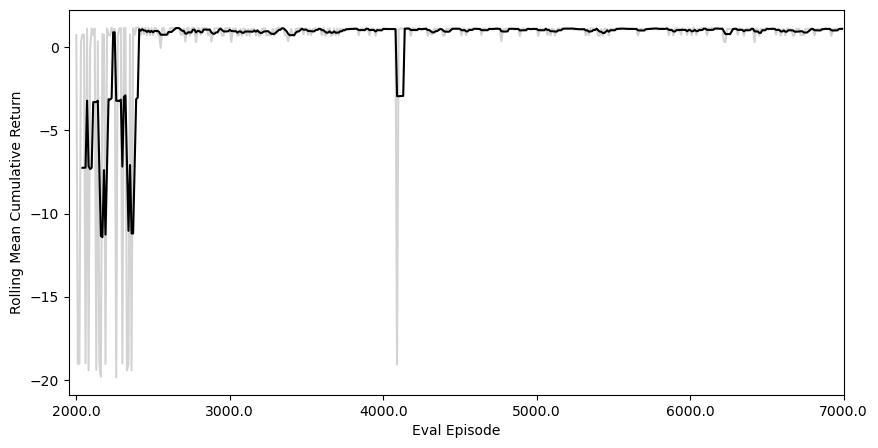

In [18]:
evaluation_log = np.load(eval_log_path + '/evaluations.npz')
evaluation_log_df = pd.DataFrame({item: [np.mean(ep) for ep in evaluation_log[item]] for item in evaluation_log.files})
ax = evaluation_log_df.loc[0:len(evaluation_log_df), 'results'].plot(color = 'lightgray', xlim = [-5, len(evaluation_log_df)], figsize = (10,5))
evaluation_log_df['results'].rolling(5).mean().plot(color = 'black', xlim = [-5, len(evaluation_log_df)])
ax.set_xticklabels(evaluation_log_df['timesteps'])
ax.set_xlabel("Eval Episode")
plt.ylabel("Rolling Mean Cumulative Return")
plt.show()

In [19]:
# Evaluating the agent in the environment for 30 episodes
agent.set_env(eval_env)
mean_reward, std_reward = sb3.common.evaluation.evaluate_policy(agent, 
                                                                agent.get_env(), 
                                                                n_eval_episodes=30)

print("Mean Reward: {} +/- {}".format(mean_reward, std_reward))

Mean Reward: 1.1031748333333333 +/- 0.048535941233333026


In [20]:
env2 = ConnectFourGym(agent2="negamax")

In [21]:
check_env(env2)

/home/pelin/Desktop/advancedml/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py:30: UserWarning: It seems that your observation  is an image but its `dtype` is (int64) whereas it has to be `np.uint8`. If your observation is not an image, we recommend you to flatten the observation to have only a 1D vector
  warnings.warn(
/home/pelin/Desktop/advancedml/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py:38: UserWarning: It seems that your observation space  is an image but the upper and lower bounds are not in [0, 255]. Because the CNN policy normalize automatically the observation you may encounter issue if the values are not in that range.
  warnings.warn(
/home/pelin/Desktop/advancedml/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py:51: UserWarning: The minimal resolution for an image is 36x36 for the default `CnnPolicy`. You might need to use a custom features extractor cf. https://stable-baselines3.readthedocs.io/en/master/gui

In [22]:
env2 = Monitor(env2)
env2 = DummyVecEnv([lambda: env2])

In [23]:
#Creating an evaluation callback that is called every at regular intervals and renders the episode
eval_log_path2 = './log_connectx2'
eval_env2= Monitor(Monitor(ConnectFourGym()))

eval_env2=DummyVecEnv([lambda:eval_env2])

eval_callback2 = EvalCallback(eval_env2 , 
                              best_model_save_path=eval_log_path2 ,
                              log_path=eval_log_path2 , 
                              eval_freq=1000,
                              render=False)

In [24]:
agent.set_env(env2)
# Train the model for a large number of timesteps
agent.learn(total_timesteps=500000,
            reset_num_timesteps = False,
           callback = eval_callback)

Eval num_timesteps=501000, episode_reward=1.14 +/- 0.06
Episode length: 6.80 +/- 2.48
---------------------------------
| eval/              |          |
|    mean_ep_length  | 6.8      |
|    mean_reward     | 1.14     |
| time/              |          |
|    total_timesteps | 501000   |
---------------------------------
Eval num_timesteps=502000, episode_reward=0.75 +/- 0.79
Episode length: 7.20 +/- 1.72
---------------------------------
| eval/              |          |
|    mean_ep_length  | 7.2      |
|    mean_reward     | 0.748    |
| time/              |          |
|    total_timesteps | 502000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.1      |
|    ep_rew_mean     | -3.74    |
| time/              |          |
|    fps             | 28       |
|    iterations      | 1        |
|    time_elapsed    | 54       |
|    total_timesteps | 502272   |
---------------------------------
Eval num_tim

Eval num_timesteps=511000, episode_reward=1.07 +/- 0.00
Episode length: 4.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 4        |
|    mean_reward     | 1.07     |
| time/              |          |
|    total_timesteps | 511000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.22     |
|    ep_rew_mean     | -2.75    |
| time/              |          |
|    fps             | 21       |
|    iterations      | 7        |
|    time_elapsed    | 500      |
|    total_timesteps | 511488   |
---------------------------------
Eval num_timesteps=512000, episode_reward=1.08 +/- 0.01
Episode length: 4.20 +/- 0.40
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 4.2         |
|    mean_reward          | 1.08        |
| time/                   |             |
|    total_timesteps      | 512000      

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.78     |
|    ep_rew_mean     | -0.759   |
| time/              |          |
|    fps             | 21       |
|    iterations      | 13       |
|    time_elapsed    | 909      |
|    total_timesteps | 520704   |
---------------------------------
Eval num_timesteps=521000, episode_reward=1.11 +/- 0.04
Episode length: 5.80 +/- 1.60
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5.8          |
|    mean_reward          | 1.11         |
| time/                   |              |
|    total_timesteps      | 521000       |
| train/                  |              |
|    approx_kl            | 0.0016259606 |
|    clip_fraction        | 0.000163     |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.334       |
|    explained_variance   | 0.176        |
|    learning_rate        | 0.000144     |
|    loss      

Eval num_timesteps=530000, episode_reward=1.09 +/- 0.02
Episode length: 4.80 +/- 0.98
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 4.8          |
|    mean_reward          | 1.09         |
| time/                   |              |
|    total_timesteps      | 530000       |
| train/                  |              |
|    approx_kl            | 0.0011574447 |
|    clip_fraction        | 0.000488     |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.338       |
|    explained_variance   | 0.283        |
|    learning_rate        | 0.000141     |
|    loss                 | 14.2         |
|    n_updates            | 2760         |
|    policy_gradient_loss | -0.00414     |
|    value_loss           | 35.5         |
------------------------------------------
Eval num_timesteps=531000, episode_reward=1.09 +/- 0.03
Episode length: 4.80 +/- 1.17
---------------------------------
| eval/             

Eval num_timesteps=540000, episode_reward=1.10 +/- 0.05
Episode length: 5.00 +/- 2.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 5             |
|    mean_reward          | 1.1           |
| time/                   |               |
|    total_timesteps      | 540000        |
| train/                  |               |
|    approx_kl            | 0.00053017883 |
|    clip_fraction        | 0             |
|    clip_range           | 0.4           |
|    entropy_loss         | -0.386        |
|    explained_variance   | 0.0775        |
|    learning_rate        | 0.000138      |
|    loss                 | 4.95          |
|    n_updates            | 2808          |
|    policy_gradient_loss | -0.00228      |
|    value_loss           | 22.2          |
-------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.62     |
|    ep_rew_mean    

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.91     |
|    ep_rew_mean     | -1.73    |
| time/              |          |
|    fps             | 20       |
|    iterations      | 32       |
|    time_elapsed    | 2400     |
|    total_timesteps | 549888   |
---------------------------------
Eval num_timesteps=550000, episode_reward=1.18 +/- 0.12
Episode length: 8.40 +/- 4.84
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 8.4         |
|    mean_reward          | 1.18        |
| time/                   |             |
|    total_timesteps      | 550000      |
| train/                  |             |
|    approx_kl            | 0.001428072 |
|    clip_fraction        | 0           |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.361      |
|    explained_variance   | 0.346       |
|    learning_rate        | 0.000135    |
|    loss                 | 

Eval num_timesteps=559000, episode_reward=1.10 +/- 0.06
Episode length: 5.40 +/- 2.33
---------------------------------
| eval/              |          |
|    mean_ep_length  | 5.4      |
|    mean_reward     | 1.1      |
| time/              |          |
|    total_timesteps | 559000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.06     |
|    ep_rew_mean     | -0.792   |
| time/              |          |
|    fps             | 20       |
|    iterations      | 38       |
|    time_elapsed    | 2808     |
|    total_timesteps | 559104   |
---------------------------------
Eval num_timesteps=560000, episode_reward=0.70 +/- 0.80
Episode length: 5.00 +/- 1.55
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 5             |
|    mean_reward          | 0.695         |
| time/                   |               |
|    total_timesteps      | 56

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.96     |
|    ep_rew_mean     | -0.674   |
| time/              |          |
|    fps             | 20       |
|    iterations      | 44       |
|    time_elapsed    | 3254     |
|    total_timesteps | 568320   |
---------------------------------
Eval num_timesteps=569000, episode_reward=1.14 +/- 0.07
Episode length: 7.00 +/- 2.97
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 7            |
|    mean_reward          | 1.14         |
| time/                   |              |
|    total_timesteps      | 569000       |
| train/                  |              |
|    approx_kl            | 0.0006846444 |
|    clip_fraction        | 0.000244     |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.342       |
|    explained_variance   | 0.382        |
|    learning_rate        | 0.00013      |
|    loss      

Eval num_timesteps=578000, episode_reward=0.71 +/- 0.76
Episode length: 5.80 +/- 1.94
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5.8          |
|    mean_reward          | 0.714        |
| time/                   |              |
|    total_timesteps      | 578000       |
| train/                  |              |
|    approx_kl            | 0.0005131804 |
|    clip_fraction        | 0            |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.345       |
|    explained_variance   | 0.392        |
|    learning_rate        | 0.000127     |
|    loss                 | 16.7         |
|    n_updates            | 3008         |
|    policy_gradient_loss | -0.00233     |
|    value_loss           | 31           |
------------------------------------------
Eval num_timesteps=579000, episode_reward=1.11 +/- 0.05
Episode length: 5.60 +/- 1.96
---------------------------------
| eval/             

Eval num_timesteps=588000, episode_reward=1.07 +/- 0.00
Episode length: 4.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 4        |
|    mean_reward     | 1.07     |
| time/              |          |
|    total_timesteps | 588000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.94     |
|    ep_rew_mean     | -0.775   |
| time/              |          |
|    fps             | 20       |
|    iterations      | 57       |
|    time_elapsed    | 4278     |
|    total_timesteps | 588288   |
---------------------------------
Eval num_timesteps=589000, episode_reward=1.09 +/- 0.03
Episode length: 4.60 +/- 1.20
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 4.6          |
|    mean_reward          | 1.09         |
| time/                   |              |
|    total_timesteps      | 589000 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.53     |
|    ep_rew_mean     | -0.785   |
| time/              |          |
|    fps             | 20       |
|    iterations      | 63       |
|    time_elapsed    | 4763     |
|    total_timesteps | 597504   |
---------------------------------
Eval num_timesteps=598000, episode_reward=1.10 +/- 0.04
Episode length: 5.00 +/- 1.55
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 1.1          |
| time/                   |              |
|    total_timesteps      | 598000       |
| train/                  |              |
|    approx_kl            | 0.0015839854 |
|    clip_fraction        | 0.00057      |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.33        |
|    explained_variance   | 0.435        |
|    learning_rate        | 0.000121     |
|    loss      

Eval num_timesteps=607000, episode_reward=1.07 +/- 0.00
Episode length: 4.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 4             |
|    mean_reward          | 1.07          |
| time/                   |               |
|    total_timesteps      | 607000        |
| train/                  |               |
|    approx_kl            | 0.00020511406 |
|    clip_fraction        | 0             |
|    clip_range           | 0.4           |
|    entropy_loss         | -0.329        |
|    explained_variance   | -1.78         |
|    learning_rate        | 0.000118      |
|    loss                 | 1.24          |
|    n_updates            | 3160          |
|    policy_gradient_loss | -0.000498     |
|    value_loss           | 3.03          |
-------------------------------------------
Eval num_timesteps=608000, episode_reward=1.10 +/- 0.04
Episode length: 5.40 +/- 1.74
---------------------------------
| 

Eval num_timesteps=617000, episode_reward=1.09 +/- 0.03
Episode length: 4.60 +/- 1.20
---------------------------------
| eval/              |          |
|    mean_ep_length  | 4.6      |
|    mean_reward     | 1.09     |
| time/              |          |
|    total_timesteps | 617000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.01     |
|    ep_rew_mean     | -1.7     |
| time/              |          |
|    fps             | 21       |
|    iterations      | 76       |
|    time_elapsed    | 5503     |
|    total_timesteps | 617472   |
---------------------------------
Eval num_timesteps=618000, episode_reward=1.12 +/- 0.04
Episode length: 6.00 +/- 1.67
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 6            |
|    mean_reward          | 1.12         |
| time/                   |              |
|    total_timesteps      | 618000 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.86     |
|    ep_rew_mean     | -1.77    |
| time/              |          |
|    fps             | 21       |
|    iterations      | 82       |
|    time_elapsed    | 5910     |
|    total_timesteps | 626688   |
---------------------------------
Eval num_timesteps=627000, episode_reward=1.09 +/- 0.03
Episode length: 4.60 +/- 1.20
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 4.6           |
|    mean_reward          | 1.09          |
| time/                   |               |
|    total_timesteps      | 627000        |
| train/                  |               |
|    approx_kl            | 0.00051488314 |
|    clip_fraction        | 0.000407      |
|    clip_range           | 0.4           |
|    entropy_loss         | -0.364        |
|    explained_variance   | 0.455         |
|    learning_rate        | 0.000112      |
| 

Eval num_timesteps=636000, episode_reward=1.12 +/- 0.04
Episode length: 6.00 +/- 1.67
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 6            |
|    mean_reward          | 1.12         |
| time/                   |              |
|    total_timesteps      | 636000       |
| train/                  |              |
|    approx_kl            | 0.0005729461 |
|    clip_fraction        | 8.14e-05     |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.361       |
|    explained_variance   | 0.409        |
|    learning_rate        | 0.000109     |
|    loss                 | 16.5         |
|    n_updates            | 3312         |
|    policy_gradient_loss | -0.00327     |
|    value_loss           | 30.7         |
------------------------------------------
Eval num_timesteps=637000, episode_reward=1.12 +/- 0.07
Episode length: 6.20 +/- 2.86
---------------------------------
| eval/             

Eval num_timesteps=646000, episode_reward=1.16 +/- 0.10
Episode length: 7.60 +/- 4.13
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 7.6          |
|    mean_reward          | 1.16         |
| time/                   |              |
|    total_timesteps      | 646000       |
| train/                  |              |
|    approx_kl            | 0.0070183813 |
|    clip_fraction        | 0.00578      |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.368       |
|    explained_variance   | -1.77        |
|    learning_rate        | 0.000107     |
|    loss                 | 0.342        |
|    n_updates            | 3360         |
|    policy_gradient_loss | -0.00744     |
|    value_loss           | 1.74         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.66     |
|    ep_rew_mean     | -0.781   |
| ti

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.85     |
|    ep_rew_mean     | -1.71    |
| time/              |          |
|    fps             | 20       |
|    iterations      | 101      |
|    time_elapsed    | 7610     |
|    total_timesteps | 655872   |
---------------------------------
Eval num_timesteps=656000, episode_reward=1.11 +/- 0.05
Episode length: 5.60 +/- 2.06
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5.6          |
|    mean_reward          | 1.11         |
| time/                   |              |
|    total_timesteps      | 656000       |
| train/                  |              |
|    approx_kl            | 0.0007543425 |
|    clip_fraction        | 0            |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.397       |
|    explained_variance   | 0.257        |
|    learning_rate        | 0.000103     |
|    loss      

Eval num_timesteps=665000, episode_reward=0.72 +/- 0.74
Episode length: 6.00 +/- 2.76
---------------------------------
| eval/              |          |
|    mean_ep_length  | 6        |
|    mean_reward     | 0.719    |
| time/              |          |
|    total_timesteps | 665000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.14     |
|    ep_rew_mean     | -1.64    |
| time/              |          |
|    fps             | 20       |
|    iterations      | 107      |
|    time_elapsed    | 7971     |
|    total_timesteps | 665088   |
---------------------------------
Eval num_timesteps=666000, episode_reward=0.72 +/- 0.78
Episode length: 6.00 +/- 2.53
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 6            |
|    mean_reward          | 0.719        |
| time/                   |              |
|    total_timesteps      | 666000 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.07     |
|    ep_rew_mean     | -0.612   |
| time/              |          |
|    fps             | 20       |
|    iterations      | 113      |
|    time_elapsed    | 8289     |
|    total_timesteps | 674304   |
---------------------------------
Eval num_timesteps=675000, episode_reward=1.10 +/- 0.04
Episode length: 5.40 +/- 1.74
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5.4          |
|    mean_reward          | 1.1          |
| time/                   |              |
|    total_timesteps      | 675000       |
| train/                  |              |
|    approx_kl            | 0.0006326623 |
|    clip_fraction        | 0            |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.347       |
|    explained_variance   | 0.42         |
|    learning_rate        | 9.79e-05     |
|    loss      

Eval num_timesteps=684000, episode_reward=1.10 +/- 0.04
Episode length: 5.40 +/- 1.74
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 5.4           |
|    mean_reward          | 1.1           |
| time/                   |               |
|    total_timesteps      | 684000        |
| train/                  |               |
|    approx_kl            | 0.00087156956 |
|    clip_fraction        | 0             |
|    clip_range           | 0.4           |
|    entropy_loss         | -0.327        |
|    explained_variance   | 0.429         |
|    learning_rate        | 9.51e-05      |
|    loss                 | 5.91          |
|    n_updates            | 3560          |
|    policy_gradient_loss | -0.00157      |
|    value_loss           | 15            |
-------------------------------------------
Eval num_timesteps=685000, episode_reward=1.10 +/- 0.04
Episode length: 5.20 +/- 1.60
---------------------------------
| 

Eval num_timesteps=694000, episode_reward=0.75 +/- 0.83
Episode length: 7.40 +/- 2.87
---------------------------------
| eval/              |          |
|    mean_ep_length  | 7.4      |
|    mean_reward     | 0.752    |
| time/              |          |
|    total_timesteps | 694000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.06     |
|    ep_rew_mean     | -1.52    |
| time/              |          |
|    fps             | 20       |
|    iterations      | 126      |
|    time_elapsed    | 9322     |
|    total_timesteps | 694272   |
---------------------------------
Eval num_timesteps=695000, episode_reward=0.69 +/- 0.77
Episode length: 4.60 +/- 1.20
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 4.6         |
|    mean_reward          | 0.686       |
| time/                   |             |
|    total_timesteps      | 695000      

Eval num_timesteps=703000, episode_reward=1.12 +/- 0.07
Episode length: 6.00 +/- 2.76
---------------------------------
| eval/              |          |
|    mean_ep_length  | 6        |
|    mean_reward     | 1.12     |
| time/              |          |
|    total_timesteps | 703000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.69     |
|    ep_rew_mean     | -1.67    |
| time/              |          |
|    fps             | 20       |
|    iterations      | 132      |
|    time_elapsed    | 9751     |
|    total_timesteps | 703488   |
---------------------------------
Eval num_timesteps=704000, episode_reward=1.17 +/- 0.10
Episode length: 8.20 +/- 4.12
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 8.2          |
|    mean_reward          | 1.17         |
| time/                   |              |
|    total_timesteps      | 704000 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.87     |
|    ep_rew_mean     | -0.576   |
| time/              |          |
|    fps             | 20       |
|    iterations      | 138      |
|    time_elapsed    | 10223    |
|    total_timesteps | 712704   |
---------------------------------
Eval num_timesteps=713000, episode_reward=1.11 +/- 0.06
Episode length: 5.80 +/- 2.40
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5.8          |
|    mean_reward          | 1.11         |
| time/                   |              |
|    total_timesteps      | 713000       |
| train/                  |              |
|    approx_kl            | 0.0020606422 |
|    clip_fraction        | 0.000732     |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.257       |
|    explained_variance   | -0.645       |
|    learning_rate        | 8.63e-05     |
|    loss      

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.85     |
|    ep_rew_mean     | -0.417   |
| time/              |          |
|    fps             | 20       |
|    iterations      | 144      |
|    time_elapsed    | 10648    |
|    total_timesteps | 721920   |
---------------------------------
Eval num_timesteps=722000, episode_reward=1.11 +/- 0.03
Episode length: 5.60 +/- 1.36
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 5.6           |
|    mean_reward          | 1.11          |
| time/                   |               |
|    total_timesteps      | 722000        |
| train/                  |               |
|    approx_kl            | 0.00028739424 |
|    clip_fraction        | 0             |
|    clip_range           | 0.4           |
|    entropy_loss         | -0.244        |
|    explained_variance   | 0.19          |
|    learning_rate        | 8.36e-05      |
| 

Eval num_timesteps=731000, episode_reward=0.73 +/- 0.79
Episode length: 6.60 +/- 2.65
---------------------------------
| eval/              |          |
|    mean_ep_length  | 6.6      |
|    mean_reward     | 0.733    |
| time/              |          |
|    total_timesteps | 731000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.18     |
|    ep_rew_mean     | -1.4     |
| time/              |          |
|    fps             | 20       |
|    iterations      | 150      |
|    time_elapsed    | 11067    |
|    total_timesteps | 731136   |
---------------------------------
Eval num_timesteps=732000, episode_reward=1.09 +/- 0.04
Episode length: 4.80 +/- 1.60
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 4.8           |
|    mean_reward          | 1.09          |
| time/                   |               |
|    total_timesteps      | 73

Eval num_timesteps=740000, episode_reward=1.10 +/- 0.05
Episode length: 5.00 +/- 2.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 5        |
|    mean_reward     | 1.1      |
| time/              |          |
|    total_timesteps | 740000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.8      |
|    ep_rew_mean     | -1.51    |
| time/              |          |
|    fps             | 20       |
|    iterations      | 156      |
|    time_elapsed    | 11492    |
|    total_timesteps | 740352   |
---------------------------------
Eval num_timesteps=741000, episode_reward=-19.06 +/- 40.35
Episode length: 6.80 +/- 2.64
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 6.8          |
|    mean_reward          | -19.1        |
| time/                   |              |
|    total_timesteps      | 7410

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.01     |
|    ep_rew_mean     | -0.373   |
| time/              |          |
|    fps             | 20       |
|    iterations      | 162      |
|    time_elapsed    | 11995    |
|    total_timesteps | 749568   |
---------------------------------
Eval num_timesteps=750000, episode_reward=0.70 +/- 0.79
Episode length: 5.00 +/- 1.26
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.695       |
| time/                   |             |
|    total_timesteps      | 750000      |
| train/                  |             |
|    approx_kl            | 0.000554108 |
|    clip_fraction        | 0           |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.256      |
|    explained_variance   | 0.419       |
|    learning_rate        | 7.53e-05    |
|    loss                 | 

Eval num_timesteps=759000, episode_reward=1.11 +/- 0.06
Episode length: 5.60 +/- 2.33
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5.6          |
|    mean_reward          | 1.11         |
| time/                   |              |
|    total_timesteps      | 759000       |
| train/                  |              |
|    approx_kl            | 0.0025069623 |
|    clip_fraction        | 0.00179      |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.237       |
|    explained_variance   | -0.594       |
|    learning_rate        | 7.25e-05     |
|    loss                 | 0.29         |
|    n_updates            | 3952         |
|    policy_gradient_loss | -0.00228     |
|    value_loss           | 0.93         |
------------------------------------------
Eval num_timesteps=760000, episode_reward=1.07 +/- 0.00
Episode length: 4.00 +/- 0.00
---------------------------------
| eval/             

Eval num_timesteps=769000, episode_reward=0.33 +/- 0.97
Episode length: 6.40 +/- 2.24
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 6.4           |
|    mean_reward          | 0.329         |
| time/                   |               |
|    total_timesteps      | 769000        |
| train/                  |               |
|    approx_kl            | 0.00015429244 |
|    clip_fraction        | 0             |
|    clip_range           | 0.4           |
|    entropy_loss         | -0.293        |
|    explained_variance   | 0.394         |
|    learning_rate        | 6.98e-05      |
|    loss                 | 24.1          |
|    n_updates            | 4000          |
|    policy_gradient_loss | -0.00225      |
|    value_loss           | 45.7          |
-------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.71     |
|    ep_rew_mean    

Eval num_timesteps=778000, episode_reward=0.70 +/- 0.75
Episode length: 5.00 +/- 2.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.695       |
| time/                   |             |
|    total_timesteps      | 778000      |
| train/                  |             |
|    approx_kl            | 0.017598044 |
|    clip_fraction        | 0.0245      |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.271      |
|    explained_variance   | 0.116       |
|    learning_rate        | 6.7e-05     |
|    loss                 | 0.142       |
|    n_updates            | 4048        |
|    policy_gradient_loss | -0.0132     |
|    value_loss           | 0.342       |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.84     |
|    ep_rew_mean     | -1.43    |
| time/              |

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.36     |
|    ep_rew_mean     | -1.29    |
| time/              |          |
|    fps             | 20       |
|    iterations      | 187      |
|    time_elapsed    | 13889    |
|    total_timesteps | 787968   |
---------------------------------
Eval num_timesteps=788000, episode_reward=1.10 +/- 0.04
Episode length: 5.20 +/- 1.60
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5.2          |
|    mean_reward          | 1.1          |
| time/                   |              |
|    total_timesteps      | 788000       |
| train/                  |              |
|    approx_kl            | 0.0019791655 |
|    clip_fraction        | 0.00212      |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.288       |
|    explained_variance   | 0.359        |
|    learning_rate        | 6.38e-05     |
|    loss      

Eval num_timesteps=797000, episode_reward=1.10 +/- 0.06
Episode length: 5.20 +/- 2.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 5.2      |
|    mean_reward     | 1.1      |
| time/              |          |
|    total_timesteps | 797000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.06     |
|    ep_rew_mean     | -0.372   |
| time/              |          |
|    fps             | 20       |
|    iterations      | 193      |
|    time_elapsed    | 14233    |
|    total_timesteps | 797184   |
---------------------------------
Eval num_timesteps=798000, episode_reward=0.70 +/- 0.74
Episode length: 5.20 +/- 2.40
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 5.2           |
|    mean_reward          | 0.7           |
| time/                   |               |
|    total_timesteps      | 79

Eval num_timesteps=806000, episode_reward=1.07 +/- 0.00
Episode length: 4.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 4        |
|    mean_reward     | 1.07     |
| time/              |          |
|    total_timesteps | 806000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.72     |
|    ep_rew_mean     | -0.36    |
| time/              |          |
|    fps             | 20       |
|    iterations      | 199      |
|    time_elapsed    | 14612    |
|    total_timesteps | 806400   |
---------------------------------
Eval num_timesteps=807000, episode_reward=1.10 +/- 0.03
Episode length: 5.00 +/- 1.26
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 5             |
|    mean_reward          | 1.1           |
| time/                   |               |
|    total_timesteps      | 80

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.11     |
|    ep_rew_mean     | -0.371   |
| time/              |          |
|    fps             | 20       |
|    iterations      | 205      |
|    time_elapsed    | 14995    |
|    total_timesteps | 815616   |
---------------------------------
Eval num_timesteps=816000, episode_reward=1.10 +/- 0.06
Episode length: 5.20 +/- 2.40
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 5.2           |
|    mean_reward          | 1.1           |
| time/                   |               |
|    total_timesteps      | 816000        |
| train/                  |               |
|    approx_kl            | 0.00091409433 |
|    clip_fraction        | 0.000244      |
|    clip_range           | 0.4           |
|    entropy_loss         | -0.25         |
|    explained_variance   | -0.689        |
|    learning_rate        | 5.55e-05      |
| 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.63     |
|    ep_rew_mean     | -0.462   |
| time/              |          |
|    fps             | 21       |
|    iterations      | 211      |
|    time_elapsed    | 15303    |
|    total_timesteps | 824832   |
---------------------------------
Eval num_timesteps=825000, episode_reward=1.10 +/- 0.07
Episode length: 5.40 +/- 2.80
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5.4          |
|    mean_reward          | 1.1          |
| time/                   |              |
|    total_timesteps      | 825000       |
| train/                  |              |
|    approx_kl            | 0.0022197708 |
|    clip_fraction        | 0.000407     |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.251       |
|    explained_variance   | 0.0448       |
|    learning_rate        | 5.27e-05     |
|    loss      

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.6      |
|    ep_rew_mean     | -0.423   |
| time/              |          |
|    fps             | 21       |
|    iterations      | 217      |
|    time_elapsed    | 15794    |
|    total_timesteps | 834048   |
---------------------------------
Eval num_timesteps=835000, episode_reward=0.73 +/- 0.74
Episode length: 6.60 +/- 3.32
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 6.6          |
|    mean_reward          | 0.733        |
| time/                   |              |
|    total_timesteps      | 835000       |
| train/                  |              |
|    approx_kl            | 0.0021202534 |
|    clip_fraction        | 0.00179      |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.223       |
|    explained_variance   | 0.403        |
|    learning_rate        | 5e-05        |
|    loss      

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.75     |
|    ep_rew_mean     | -0.419   |
| time/              |          |
|    fps             | 21       |
|    iterations      | 223      |
|    time_elapsed    | 16218    |
|    total_timesteps | 843264   |
---------------------------------
Eval num_timesteps=844000, episode_reward=1.07 +/- 0.00
Episode length: 4.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 4           |
|    mean_reward          | 1.07        |
| time/                   |             |
|    total_timesteps      | 844000      |
| train/                  |             |
|    approx_kl            | 0.002286832 |
|    clip_fraction        | 0.000244    |
|    clip_range           | 0.4         |
|    entropy_loss         | -0.222      |
|    explained_variance   | 0.362       |
|    learning_rate        | 4.72e-05    |
|    loss                 | 

Eval num_timesteps=853000, episode_reward=1.11 +/- 0.06
Episode length: 5.80 +/- 2.40
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5.8          |
|    mean_reward          | 1.11         |
| time/                   |              |
|    total_timesteps      | 853000       |
| train/                  |              |
|    approx_kl            | 0.0020258257 |
|    clip_fraction        | 0.000488     |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.282       |
|    explained_variance   | 0.351        |
|    learning_rate        | 4.44e-05     |
|    loss                 | 0.133        |
|    n_updates            | 4440         |
|    policy_gradient_loss | -0.00301     |
|    value_loss           | 0.312        |
------------------------------------------
Eval num_timesteps=854000, episode_reward=0.79 +/- 0.76
Episode length: 9.00 +/- 2.00
---------------------------------
| eval/             

Eval num_timesteps=862000, episode_reward=1.10 +/- 0.04
Episode length: 5.40 +/- 1.74
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 5.4           |
|    mean_reward          | 1.1           |
| time/                   |               |
|    total_timesteps      | 862000        |
| train/                  |               |
|    approx_kl            | 0.00010414681 |
|    clip_fraction        | 0             |
|    clip_range           | 0.4           |
|    entropy_loss         | -0.268        |
|    explained_variance   | 0.296         |
|    learning_rate        | 4.17e-05      |
|    loss                 | 27            |
|    n_updates            | 4488          |
|    policy_gradient_loss | -0.000945     |
|    value_loss           | 34.2          |
-------------------------------------------
Eval num_timesteps=863000, episode_reward=1.07 +/- 0.00
Episode length: 4.00 +/- 0.00
---------------------------------
| 

Eval num_timesteps=871000, episode_reward=1.09 +/- 0.04
Episode length: 4.80 +/- 1.60
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 4.8          |
|    mean_reward          | 1.09         |
| time/                   |              |
|    total_timesteps      | 871000       |
| train/                  |              |
|    approx_kl            | 0.0013785278 |
|    clip_fraction        | 0.000244     |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.248       |
|    explained_variance   | 0.425        |
|    learning_rate        | 3.89e-05     |
|    loss                 | 0.133        |
|    n_updates            | 4536         |
|    policy_gradient_loss | -0.00209     |
|    value_loss           | 0.287        |
------------------------------------------
Eval num_timesteps=872000, episode_reward=1.13 +/- 0.08
Episode length: 6.60 +/- 3.56
---------------------------------
| eval/             

Eval num_timesteps=881000, episode_reward=1.11 +/- 0.03
Episode length: 5.80 +/- 1.47
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5.8          |
|    mean_reward          | 1.11         |
| time/                   |              |
|    total_timesteps      | 881000       |
| train/                  |              |
|    approx_kl            | 0.0003966218 |
|    clip_fraction        | 0.000163     |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.26        |
|    explained_variance   | -0.453       |
|    learning_rate        | 3.62e-05     |
|    loss                 | 0.198        |
|    n_updates            | 4584         |
|    policy_gradient_loss | -0.00354     |
|    value_loss           | 1.05         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.93     |
|    ep_rew_mean     | -0.415   |
| ti

Eval num_timesteps=890000, episode_reward=1.15 +/- 0.08
Episode length: 7.40 +/- 3.44
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 7.4          |
|    mean_reward          | 1.15         |
| time/                   |              |
|    total_timesteps      | 890000       |
| train/                  |              |
|    approx_kl            | 0.0008247804 |
|    clip_fraction        | 0.000163     |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.257       |
|    explained_variance   | 0.429        |
|    learning_rate        | 3.34e-05     |
|    loss                 | 0.132        |
|    n_updates            | 4632         |
|    policy_gradient_loss | -0.00129     |
|    value_loss           | 0.317        |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.87     |
|    ep_rew_mean     | -1.31    |
| ti

Eval num_timesteps=899000, episode_reward=1.07 +/- 0.00
Episode length: 4.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 4             |
|    mean_reward          | 1.07          |
| time/                   |               |
|    total_timesteps      | 899000        |
| train/                  |               |
|    approx_kl            | 0.00035485078 |
|    clip_fraction        | 0             |
|    clip_range           | 0.4           |
|    entropy_loss         | -0.244        |
|    explained_variance   | 0.443         |
|    learning_rate        | 3.06e-05      |
|    loss                 | 9.21          |
|    n_updates            | 4680          |
|    policy_gradient_loss | 0.000421      |
|    value_loss           | 15            |
-------------------------------------------
Eval num_timesteps=900000, episode_reward=1.10 +/- 0.05
Episode length: 5.00 +/- 2.00
---------------------------------
| 

Eval num_timesteps=908000, episode_reward=1.10 +/- 0.04
Episode length: 5.00 +/- 1.55
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 5             |
|    mean_reward          | 1.1           |
| time/                   |               |
|    total_timesteps      | 908000        |
| train/                  |               |
|    approx_kl            | 0.00014753589 |
|    clip_fraction        | 0             |
|    clip_range           | 0.4           |
|    entropy_loss         | -0.255        |
|    explained_variance   | 0.358         |
|    learning_rate        | 2.79e-05      |
|    loss                 | 0.145         |
|    n_updates            | 4728          |
|    policy_gradient_loss | -0.000776     |
|    value_loss           | 0.328         |
-------------------------------------------
Eval num_timesteps=909000, episode_reward=1.17 +/- 0.09
Episode length: 8.00 +/- 3.63
---------------------------------
| 

Eval num_timesteps=917000, episode_reward=1.11 +/- 0.06
Episode length: 5.80 +/- 2.40
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 5.8           |
|    mean_reward          | 1.11          |
| time/                   |               |
|    total_timesteps      | 917000        |
| train/                  |               |
|    approx_kl            | 2.1866988e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.4           |
|    entropy_loss         | -0.223        |
|    explained_variance   | 0.386         |
|    learning_rate        | 2.51e-05      |
|    loss                 | 0.143         |
|    n_updates            | 4776          |
|    policy_gradient_loss | -0.000351     |
|    value_loss           | 0.329         |
-------------------------------------------
Eval num_timesteps=918000, episode_reward=1.12 +/- 0.05
Episode length: 6.20 +/- 1.94
---------------------------------
| 

Eval num_timesteps=927000, episode_reward=1.13 +/- 0.05
Episode length: 6.60 +/- 2.24
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 6.6           |
|    mean_reward          | 1.13          |
| time/                   |               |
|    total_timesteps      | 927000        |
| train/                  |               |
|    approx_kl            | 0.00019289972 |
|    clip_fraction        | 0             |
|    clip_range           | 0.4           |
|    entropy_loss         | -0.258        |
|    explained_variance   | -0.226        |
|    learning_rate        | 2.23e-05      |
|    loss                 | 0.77          |
|    n_updates            | 4824          |
|    policy_gradient_loss | -0.000605     |
|    value_loss           | 1.68          |
-------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.24     |
|    ep_rew_mean    

Eval num_timesteps=936000, episode_reward=1.10 +/- 0.05
Episode length: 5.40 +/- 1.96
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5.4          |
|    mean_reward          | 1.1          |
| time/                   |              |
|    total_timesteps      | 936000       |
| train/                  |              |
|    approx_kl            | 4.372897e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.247       |
|    explained_variance   | 0.107        |
|    learning_rate        | 1.96e-05     |
|    loss                 | 18.1         |
|    n_updates            | 4872         |
|    policy_gradient_loss | -0.00164     |
|    value_loss           | 19.7         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.18     |
|    ep_rew_mean     | -0.309   |
| ti

Eval num_timesteps=945000, episode_reward=1.09 +/- 0.03
Episode length: 4.60 +/- 1.20
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 4.6           |
|    mean_reward          | 1.09          |
| time/                   |               |
|    total_timesteps      | 945000        |
| train/                  |               |
|    approx_kl            | 0.00024157744 |
|    clip_fraction        | 0             |
|    clip_range           | 0.4           |
|    entropy_loss         | -0.207        |
|    explained_variance   | 0.31          |
|    learning_rate        | 1.68e-05      |
|    loss                 | 0.15          |
|    n_updates            | 4920          |
|    policy_gradient_loss | -0.000365     |
|    value_loss           | 0.379         |
-------------------------------------------
Eval num_timesteps=946000, episode_reward=0.74 +/- 0.79
Episode length: 6.80 +/- 2.64
---------------------------------
| 

Eval num_timesteps=954000, episode_reward=-19.08 +/- 40.37
Episode length: 6.20 +/- 1.60
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 6.2           |
|    mean_reward          | -19.1         |
| time/                   |               |
|    total_timesteps      | 954000        |
| train/                  |               |
|    approx_kl            | 8.4181236e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.4           |
|    entropy_loss         | -0.223        |
|    explained_variance   | 0.00701       |
|    learning_rate        | 1.41e-05      |
|    loss                 | 10.6          |
|    n_updates            | 4968          |
|    policy_gradient_loss | -0.000746     |
|    value_loss           | 20.9          |
-------------------------------------------
Eval num_timesteps=955000, episode_reward=0.72 +/- 0.76
Episode length: 6.20 +/- 2.71
---------------------------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.73     |
|    ep_rew_mean     | -0.32    |
| time/              |          |
|    fps             | 21       |
|    iterations      | 301      |
|    time_elapsed    | 21751    |
|    total_timesteps | 963072   |
---------------------------------
Eval num_timesteps=964000, episode_reward=-19.06 +/- 40.36
Episode length: 6.80 +/- 2.48
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 6.8           |
|    mean_reward          | -19.1         |
| time/                   |               |
|    total_timesteps      | 964000        |
| train/                  |               |
|    approx_kl            | 0.00022511762 |
|    clip_fraction        | 0             |
|    clip_range           | 0.4           |
|    entropy_loss         | -0.21         |
|    explained_variance   | 0.353         |
|    learning_rate        | 1.13e-05      |

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.51     |
|    ep_rew_mean     | -0.325   |
| time/              |          |
|    fps             | 21       |
|    iterations      | 307      |
|    time_elapsed    | 22167    |
|    total_timesteps | 972288   |
---------------------------------
Eval num_timesteps=973000, episode_reward=1.14 +/- 0.06
Episode length: 6.80 +/- 2.71
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 6.8           |
|    mean_reward          | 1.14          |
| time/                   |               |
|    total_timesteps      | 973000        |
| train/                  |               |
|    approx_kl            | 0.00013435404 |
|    clip_fraction        | 0             |
|    clip_range           | 0.4           |
|    entropy_loss         | -0.213        |
|    explained_variance   | 0.484         |
|    learning_rate        | 8.53e-06      |
| 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.27     |
|    ep_rew_mean     | -1.2     |
| time/              |          |
|    fps             | 21       |
|    iterations      | 313      |
|    time_elapsed    | 22693    |
|    total_timesteps | 981504   |
---------------------------------
Eval num_timesteps=982000, episode_reward=1.09 +/- 0.03
Episode length: 4.60 +/- 1.20
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 4.6           |
|    mean_reward          | 1.09          |
| time/                   |               |
|    total_timesteps      | 982000        |
| train/                  |               |
|    approx_kl            | 3.8616904e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.4           |
|    entropy_loss         | -0.215        |
|    explained_variance   | 0.399         |
|    learning_rate        | 5.77e-06      |
| 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.29     |
|    ep_rew_mean     | -2.35    |
| time/              |          |
|    fps             | 21       |
|    iterations      | 319      |
|    time_elapsed    | 23185    |
|    total_timesteps | 990720   |
---------------------------------
Eval num_timesteps=991000, episode_reward=1.09 +/- 0.03
Episode length: 4.60 +/- 1.20
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 4.6          |
|    mean_reward          | 1.09         |
| time/                   |              |
|    total_timesteps      | 991000       |
| train/                  |              |
|    approx_kl            | 7.036142e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.4          |
|    entropy_loss         | -0.218       |
|    explained_variance   | 0.17         |
|    learning_rate        | 3e-06        |
|    loss      

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.37     |
|    ep_rew_mean     | -1.15    |
| time/              |          |
|    fps             | 21       |
|    iterations      | 325      |
|    time_elapsed    | 23564    |
|    total_timesteps | 999936   |
---------------------------------
Eval num_timesteps=1000000, episode_reward=1.16 +/- 0.08
Episode length: 7.60 +/- 3.38
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 7.6           |
|    mean_reward          | 1.16          |
| time/                   |               |
|    total_timesteps      | 1000000       |
| train/                  |               |
|    approx_kl            | 1.0904235e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.4           |
|    entropy_loss         | -0.232        |
|    explained_variance   | 0.427         |
|    learning_rate        | 2.4e-07       |
|

/tmp/ipykernel_7549/1689855701.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(evaluation_log2_df['timesteps'])


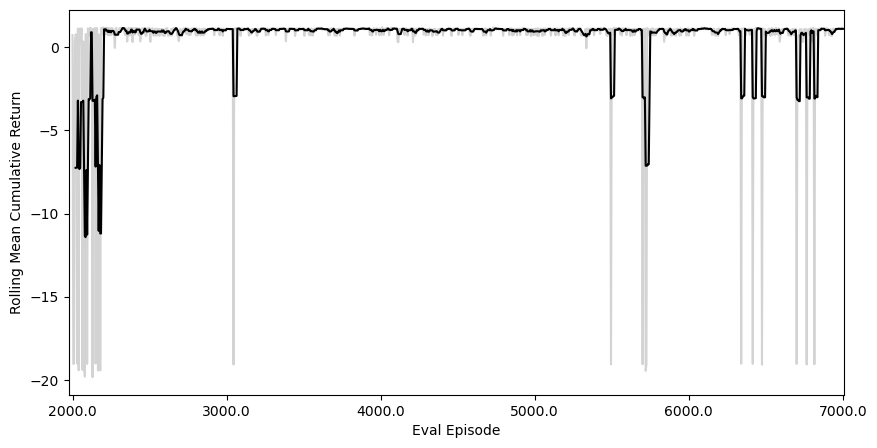

In [25]:
evaluation_log2 = np.load(eval_log_path + '/evaluations.npz')
evaluation_log2_df = pd.DataFrame({item: [np.mean(ep) for ep in evaluation_log2[item]] for item in evaluation_log2.files})
ax = evaluation_log2_df.loc[0:len(evaluation_log2_df), 'results'].plot(color = 'lightgray', xlim = [-5, len(evaluation_log2_df)], figsize = (10,5))
evaluation_log2_df['results'].rolling(5).mean().plot(color = 'black', xlim = [-5, len(evaluation_log2_df)])
ax.set_xticklabels(evaluation_log2_df['timesteps'])
ax.set_xlabel("Eval Episode")
plt.ylabel("Rolling Mean Cumulative Return")
plt.show()

In [26]:
# Evaluating the agent in the environment for 30 episodes
agent.set_env(eval_env2)
mean_reward, std_reward = sb3.common.evaluation.evaluate_policy(agent, 
                                                                agent.get_env(), 
                                                                n_eval_episodes=30)

print("Mean Reward: {} +/- {}".format(mean_reward, std_reward))

Mean Reward: 0.921428833333333 +/- 0.5821790464617728


In [27]:
agent.save("./ppo_connectx")

## Evaluating my agent

In [28]:
agent.predict(env.reset())

(array([2]), None)

In [29]:
def testagent(obs, config):
    import numpy as np
    obs = np.array(obs['board']).reshape(1, config.rows, config.columns)
    action, _ = agent.predict(obs)
    return int(action)

In [30]:
def get_win_percentages(agent1, agent2, n_rounds=100):
    # Use default Connect Four setup
    config = {'rows': 6, 'columns': 7, 'inarow': 4}
    # Agent 1 goes first (roughly) half the time          
    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    # Agent 2 goes first (roughly) half the time      
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
    print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
    print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
    print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))

In [34]:
get_win_percentages(agent1=testagent, agent2="negamax")

Agent 1 Win Percentage: 0.18
Agent 2 Win Percentage: 0.81
Number of Invalid Plays by Agent 1: 1
Number of Invalid Plays by Agent 2: 0


In [32]:
get_win_percentages(agent1=testagent, agent2="random")

Agent 1 Win Percentage: 0.82
Agent 2 Win Percentage: 0.17
Number of Invalid Plays by Agent 1: 1
Number of Invalid Plays by Agent 2: 0


In [33]:
env = make("connectx", debug=True)

# Two random agents play one game round
env.run([testagent, "negamax"])

# Show the game
env.render(mode="ipython")

In [35]:
env.play([None, testagent ], width=500, height=450)

## Writing submission file and Validating

I found  ["Connect4: make submission with stable-baselines3"](https://www.kaggle.com/code/toshikazuwatanabe/connect4-make-submission-with-stable-baselines3) to be extremely helpful in learning how to write a submission file. I want to express my gratitude to [noypeban](https://www.kaggle.com/toshikazuwatanabe)  for sharing this notebook. Thank you very much!

In [36]:
%%writefile submission.py
def agent(obs, config):
    import numpy as np
    import torch as th
    from torch import nn as nn
    from torch import tensor
    
    class Net(nn.Module):
        def __init__(self):
            super(Net,self).__init__()
            n_inputs= 42
            n_actions=7
            self.policy1 = nn.Linear(in_features=42, out_features=64, bias=True)
            self.policy2 = nn.Linear(in_features=64, out_features=64, bias=True)
            self.action = nn.Linear(in_features=64, out_features=7, bias=True)
            self.out_activ = nn.Softmax(dim=1)
        def forward(self,x):
            x = nn.Flatten(start_dim = 1, end_dim = -1)(x)
            x = nn.Flatten(start_dim = 1, end_dim = -1)(x)
            x = th.tanh(self.policy1(x))
            x = th.tanh(self.policy2(x))
            x = self.action(x)
            x = self.out_activ(x)
            x = x.argmax()
            return x
            

Writing submission.py


In [37]:
agent = sb3.PPO.load("./ppo_connectx")

In [38]:
agent.policy.state_dict().keys()

odict_keys(['mlp_extractor.policy_net.0.weight', 'mlp_extractor.policy_net.0.bias', 'mlp_extractor.policy_net.2.weight', 'mlp_extractor.policy_net.2.bias', 'mlp_extractor.value_net.0.weight', 'mlp_extractor.value_net.0.bias', 'mlp_extractor.value_net.2.weight', 'mlp_extractor.value_net.2.bias', 'action_net.weight', 'action_net.bias', 'value_net.weight', 'value_net.bias'])

In [39]:
th.set_printoptions(profile="full")

agent_path = 'submission.py'

state_dict = agent.policy.to('cpu').state_dict()
state_dict ={
    'policy1.weight':state_dict['mlp_extractor.policy_net.0.weight'],
    'policy1.bias':state_dict['mlp_extractor.policy_net.0.bias'],
    'policy2.weight':state_dict['mlp_extractor.policy_net.2.weight'],
    'policy2.bias':state_dict['mlp_extractor.policy_net.2.bias'],
    'action.weight':state_dict['action_net.weight'],
    'action.bias':state_dict['action_net.bias'],
}

with open(agent_path, mode='a') as file:
    file.write(f'    state_dict = {state_dict}\n')

In [40]:
%%writefile -a submission.py
    model = Net()
    model = model.float()
    model.load_state_dict(state_dict)
    model = model.to('cpu')
    model = model.eval()
    obs = tensor(obs['board']).reshape(1, 1, config.rows, config.columns).float()
    action = model(obs)
    return int(action)

Appending to submission.py


### Validate Submission¶

In [41]:
agent=None
f = open(agent_path)
source = f.read()
exec(source)

In [42]:
agent(env.reset()[0]['observation'], env.configuration)

2

In [43]:
get_win_percentages(agent1=agent, agent2="negamax")

Agent 1 Win Percentage: 0.12
Agent 2 Win Percentage: 0.87
Number of Invalid Plays by Agent 1: 1
Number of Invalid Plays by Agent 2: 0


In [44]:
env = make("connectx", debug=True)

# Two random agents play one game round
env.run([agent, agent])

# Show the game
env.render(mode="ipython")

In [45]:
env = make("connectx", debug=True)
env.run([agent, agent])
print("Success!" if env.state[0].status == env.state[1].status == "DONE" else "Failed...")

Success!


## Result 

<div style=" background-color: rgb(218, 255, 215);
             border-style: outset;
             padding: 10px;
             margin: 10px;
             text-indent: 10px;
             text-align: justify;
             letter-spacing: 1px;
             line-height: 200%">
    <h4> &#x1F913; This is my personal reflections and I welcome any corrections or suggestions for improvement. &#x1F4BB; </h4>
    <ul>
        <li style = "margin: 10px"> I implemented linear learning rate decay, as shown in the <a href="https://stable-baselines3.readthedocs.io/en/master/guide/examples.html#learning-rate-schedule">documentation</a>  example. However, it may be beneficial to introduce adeptive decay to aid in model convergence. </li> 
        <li style = "margin: 10px"> To ensure that my agent did not make invalid moves, I heavily penalized such actions. However, this hinder exploration. Therefore, it may be worth exploring PPO with invalid action masking.  </li> 
        <li style = "margin: 10px"> The performance of my agent is resonably bad but I think my model is still undertrained and needs more training. However, I need to to pause the experiment until I figure out how to parallelize the training process in Kaggle environments. The current training process takes up too much time and is overwhelming.  </li> 
</ul>

<h4> I would appreciate your guidance on the tasks I attempted but struggled with or found perplexing.:</h4>
    <ul>
        <li style = "margin: 10px"> I'm facing a challenge with converting the Kaggle environment into a vectorized gymnasium environment to speed up my training process by trainning in parallel environments. </li> 
        <li style = "margin: 10px"> During my initial testing, I found that my model performed much worse when orthogonal weight initialization was set to true. Therefore, I opted to set it to false for the actual training stage. However, I have come across papers and forum posts suggesting that using orthogonal weight initialization with PPO can aid in model convergence so I am confused. </li> 
               <li style = "margin: 10px"> The default CNN policy of SB3 had a minimum image size requirement that was not met by the input values. To address this, I opted to use a vector agent instead of creating a custom CNN policy. I stumbled upon some notebooks that utilized a customized CNN policy. I'm curious about the reasoning behind choosing a CNN policy with PPO for this particular environment. From what I observed, the notebooks didn't demonstrate superior performance, likely due to insufficient training. Would anyone who has experimented with PPO with CNN policy for a significant amount of time be willing to share performance results? </li> 
</ul>
</div>